# Natural Language Processing with Disaster tweets

In this project, we are using Natural Language Processing to predict whether a tweet is referring to a disasters’ occurrence or not. We first start with reading the dataset and perform an extensive Exploratary Data Analysis to better understand all the features, which can help us decide the approach we want to model our data on. We then move on to the Data preprocessing stage, where we clean our data and convert it to a form which can then be fed to a Machine Learning model. Once our dataset is cleaned, we train various models on our dataset. Once our models are trained, we can now use them to apply prediction on unknown test dataset. In the end, we can evaluate our model's performance based on the results received from the prediction methods and understand which Machine Learning methodology works best for our Disaster Tweets dataset.

### Necessary imports

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nltk.corpus import stopwords
import string
import re
from autocorrect import Speller
from keybert import KeyBERT
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score, matthews_corrcoef
import spacy
import missingno as msno
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score, auc
from keras.layers import Dense, LSTM, Embedding, Activation, Dropout
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from transformers import BertTokenizer
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

## Step1: Reading the data

Reading train and test dataset in 'df_train' and 'df_test'.

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


We can drop the 'id' attribute in train and test datasets as it's a unique value without much significance.

In [5]:
df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.0+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   3237 non-null   object
 1   location  2158 non-null   object
 2   text      3263 non-null   object
dtypes: object(3)
memory usage: 76.6+ KB


We have a total of 7613 sample tweets in training dataset and 3263 sample tweets in test dataset.

# Step 2: Exploratory Data Analysis (EDA)

We will perform the EDA on training dataset to understand it better

Checking the dataset for any missing values.

In [8]:
df_train.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
df_test.isna().sum()

keyword       26
location    1105
text           0
dtype: int64

In train dataset, we have '61' missing values in 'keyword' attribute and '2533' missing values in 'location' attribute.  
In test dataset, we have '26' missing values in 'keyword' attribute and '1105' missing values in 'location' attribute.

<AxesSubplot:>

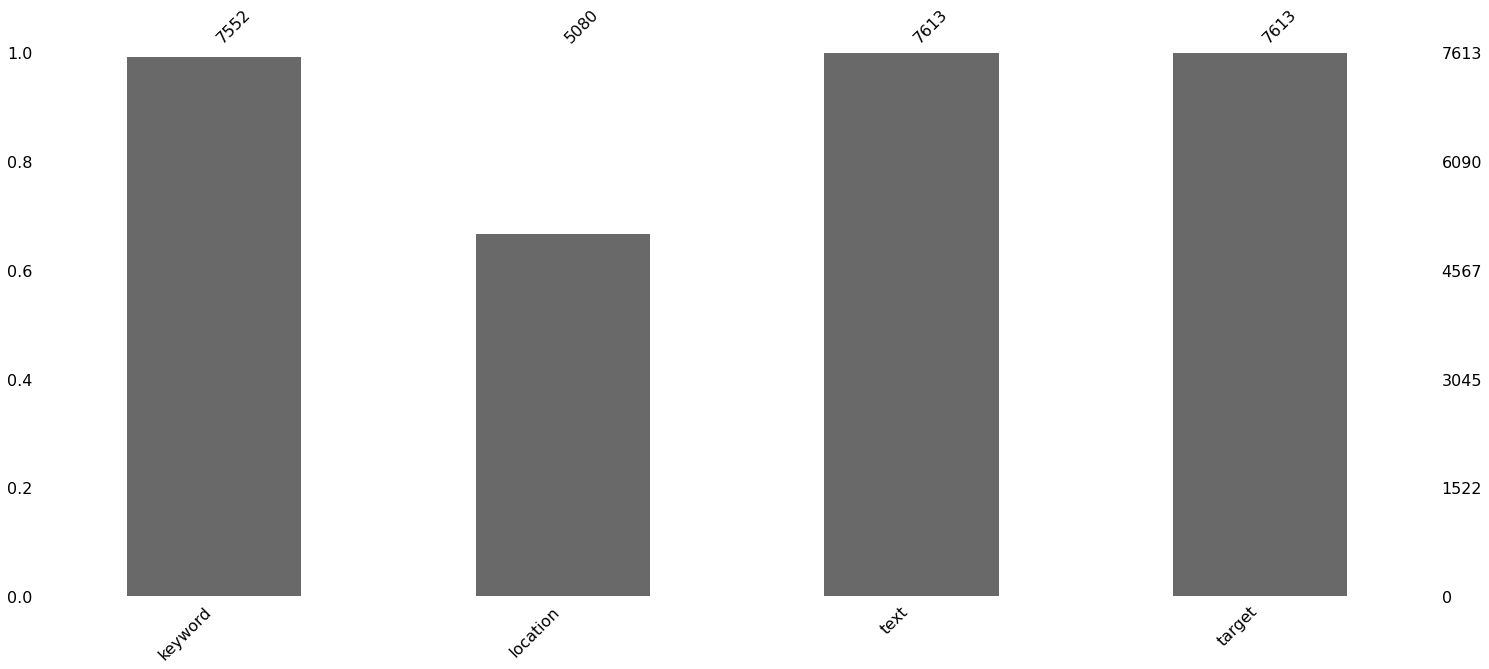

In [10]:
# Total number of samples in each attribute
import missingno as msno
# We are using python's missingno library to plot the non-null values in each column
msno.bar(df_train)

Let's have a look at data in each column for a better understanding.

'Keyword' column:

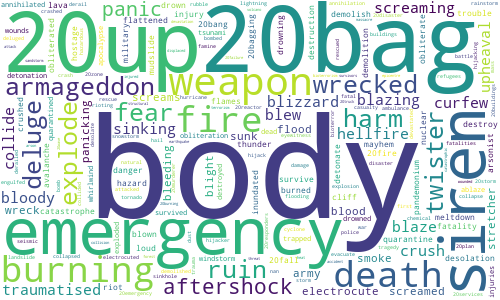

In [11]:
wordcloud_nonDisaster = WordCloud(background_color='white', width=500, height=300, collocations=False).generate(' '.join(str(v) for v in df_train['keyword'][df_train['target'] == 0]))
wordcloud_disaster = WordCloud(background_color='white', width=500, height=300, collocations=False).generate(' '.join(str(v) for v in df_train['keyword'][df_train['target'] == 0]))
wordcloud_nonDisaster.to_image()

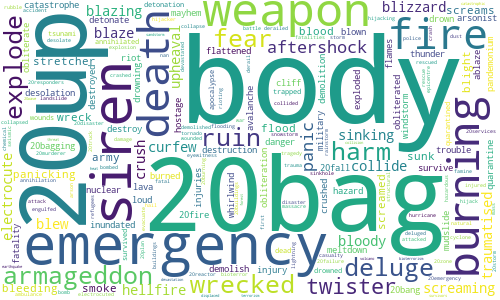

In [12]:
wordcloud_disaster.to_image()

Observations: From the above word cloud, we can see that there are a lot of common words in both the categories such as body, bag, siren , emergency. Therfore, we need to create exclusive and non-exclusive disaster words before we create a vector of all the words in dataset.

Also there are a lot of white spaces as can be seen by the appearance of '%20' in tweets such as '%20bag' and '%20up'. As these white spaces are adding noise to our data, we will remove them in the data-preprocessing stage.

'Location' column:

As we have a majority of 'NaN' values in the 'location' column, to understand the other values better, we will only visualize the non-null values.

<AxesSubplot:xlabel='location'>

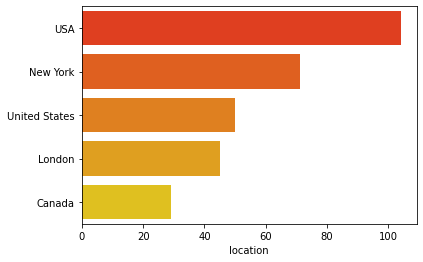

In [13]:
sns.barplot(y = df_train['location'].value_counts()[:5].index, x = df_train['location'].value_counts()[:5],
            palette='autumn')

After the missing NAN values, the majority of tweets are from 'USA' and 'New York' as seen above.

'Text' column:  
Let's have a look at the length of tweets to understand if there's a trend between length of a tweet and it belonging to a particular category.  
We will create a new column to determine length of each tweet, which we will drop later after the visualization is done.

In [14]:
df_train['text_length'] = df_train['text'].apply(len)

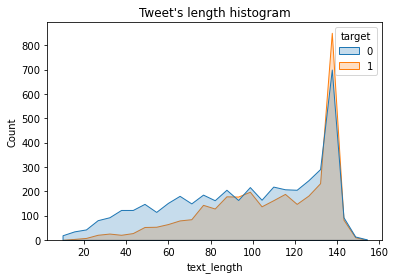

In [15]:
sns.histplot(data=df_train, x='text_length', hue='target', element="poly").set(title="Tweet's length histogram")
plt.savefig('TweetsLengthClassification.png', bbox_inches='tight')

Here, we can observe that tweet’s whose length is closer to maximum tweet’s length belong to the 1 category i.e., a disaster, with approximate more than 800 tweets belonging to this category. Here we can conclude that a tweet which is longer in length and contains more words can be a disaster and can be looked into further.

In [16]:
np.mean(df_train[df_train['target']==1]['text_length'])

108.11342097217977

In [17]:
np.mean(df_train[df_train['target']==0]['text_length'])

95.70681713496084

Observation: It is noted that the average length of tweet belonging to a disaster category is 108 words whereas the average length of non-disastrous category is 95 words.

In [18]:
# We can drop the length column now that we've used it for visualization
df_train = df_train.drop('text_length', axis=1)

'Target' column:  
For the target values, we can have a look at the class distribution to understand which in category more tweets belong to for our dataset.

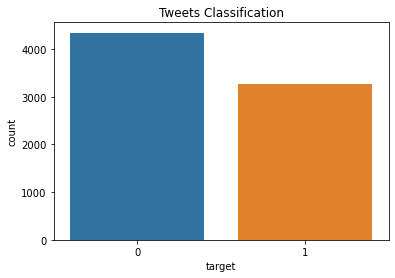

In [19]:
sns.countplot(data=df_train, x='target').set(title="Tweets Classification")
plt.savefig('TweetsClassification.png', bbox_inches='tight')

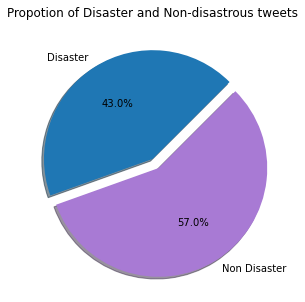

In [20]:
fig = plt.figure(figsize=(5,5))
colors=["#1F77B4",'#A87AD4']
disaster=df_train['target'][df_train['target'] == 1]
nonDisaster=df_train['target'][df_train['target'] == 0]
ck=[disaster.count(),nonDisaster.count()]
legpie=plt.pie(ck,labels=["Disaster","Non Disaster"],
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))
plt.title("Propotion of Disaster and Non-disastrous tweets")
plt.savefig('TweetsClassification_pie.png', bbox_inches='tight')
plt.show()

For our problem, we have a total of 7613 records, out of which we have 4342 tweets (57%) belonging to 0 category i.e., not a disaster and 3271 (43%) tweets belonging to disaster category. From this, we can conclude that our data is not severely imbalanced but not perfectly balanced as well at the same time.

## Step 3: Data/Text Preprocessing

Our tweets at the moment can not be considered clean as they contain a lot of stopwords, punctuaions, hashtags, misspelled words, @ tags etc. Therefore, these needs to be removed before converting the tweets into vectors.

But before we proceed with removing these words, we need to perform feature extraction to fill the missing values in 'location' and 'keyword' columns. We will only apply the below custom methods to clean our tweets.

<ol>
    <li>Remove %20 character from tweets</li>
    <li>Converting tweets to lowercase</li>
    <li>Removing urls from tweets</li>
    <li>Removing '@' and '#' entities</li>
    <li>Correcting misspelled words</li>
</ol>

In [21]:
# custom method to remove %20 from tweets
def removePercent20(str):
    try:
        str = str.split("%20")
        str = ' '.join(str)
        return str
    except:
        return str

In [22]:
# custom method to convert text to lowercase
def toLowerCase(str):
    if pd.isna(str) != True:
        return str.lower()
    return str

In [23]:
# Custom method to remove entities starting with @ and #
def removing_entities(str):
    prefixes = ['@', '#']
    tweet = str.split()
    words = []
    for word in tweet:
        word = word.strip()
        if word:
            if word[0] not in prefixes:
                words.append(word)
    text = ' '.join(words)
    return text

In [24]:
# Custom method to remove urls from tweet
def removing_urls(str):
    tweet = str.split()
    words = []
    for word in tweet:
        word = word.strip()
        if pd.isna(word) != True:
            words.append(re.sub(r"(?:\@|http?\://|https?\://|www)\S+",'', word))
    text = ' '.join(words)
    return re.sub(' +', ' ', text).strip()

In [25]:
# Custom method to correct the incorrect spellings in tweet
# We are using python's speller library to convert the incorrect words back to it's original form
spell = Speller(lang='en')
def correcting_spellings(str):
    correctWords = [spell(word) for word in str.split()]
    correctWords = ' '.join(correctWords)
    return correctWords

Using the above custom methods, we can transform our tweets to a make them more clean then they were in it's original form.

In [26]:
# Text cleaning before filling the missing data
def text_processing(str):
    removePer20 = removePercent20(str)
    lowerCase = toLowerCase(removePer20)
    urlsRemoved = removing_urls(lowerCase)
    entitiesRemoved = removing_entities(urlsRemoved)
    spellChecked = correcting_spellings(entitiesRemoved)
    return spellChecked

In [27]:
# Apply the above text processing on 'text' attribute of train and test dataset
start_time = time.time()
df_train['text'] = df_train['text'].apply(text_processing)
print("Train(text) column processing time %s seconds" % (time.time() - start_time))

start_time = time.time()
df_test['text'] = df_test['text'].apply(text_processing)
print("Test(text) column processing time %s seconds" % (time.time() - start_time)) 

Train(text) column processing time 278.33977603912354 seconds
Test(text) column processing time 120.00343370437622 seconds


The text processing is not complete yet. We need to remove punctuations and stopwords from the 'text' attribute. However, we will first utilize the 'text' attribute to fill missing values in the 'keyword' and 'location' columns.

In [28]:
# Semi clean Train Data
df_train['text'].head()
#df_test['text'].head()

0    our deeds are the reason of this may alla forg...
1               forest fire near la range task. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive evacuation orders in cal...
4    just got sent this photo from ruby as smoke fr...
Name: text, dtype: object

### Dealing with Missing Data & Feature Extraction

In this section, we will try to fill the missing values in 'keyword' and 'location' columns by extracting the valuable information from the 'text' attribute column.

In [29]:
print("Missing values in 'keyword' column: ",df_train['keyword'].isna().sum())

Missing values in 'keyword' column:  61


We are using 'keyBERT' model which is a keyword extraction technique that uses BERT embeddings to extract the most similar keywords and keyphrases from a text.

In [30]:
#keyBert model for 'keyword' extraction
from keybert import KeyBERT
kw_model = KeyBERT()
def extracting_keyword(str):
    try:
        return kw_model.extract_keywords(str)[0][0]
    except:
        return "unknown"

In [31]:
# A sample tweet to demostrate how keyBERT works
extracting_keyword("Hey i almost died yesterday")

'died'

In [32]:
extracting_keyword("Hey i almost crashed my car yesterday")

'crashed'

The kw_model works in such a way that it returns the weightage of most significant word in a sentence. An example can be seen below:

In [33]:
kw_model.extract_keywords("I almost crashed my car yesterday")

[('crashed', 0.6328), ('car', 0.3885), ('yesterday', 0.3335)]

We have a 'keyBert' model that can give us the most signifant word in a sentence. Now, we can fill our missing values in the 'keyword' column in train and test data using the above model

In [34]:
# Custom method to fill the missing values in 'keyword' column in train dataset
def fill_keyword(data):    
    for i in range(len(data['keyword'])):
        if pd.isnull(data['keyword'][i]):
                data['keyword'][i] = extracting_keyword(data['text'][i])

In [35]:
df_train['keyword'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: keyword, dtype: object

In [36]:
start_time = time.time()
fill_keyword(df_train)
print("%s seconds " % (time.time() - start_time))

6.04105544090271 seconds 


In [37]:
#Checking values after applying the 'fill_keyword' custom method to train dataset
df_train['keyword'].head()

0       forgive
1        forest
2    evacuation
3    evacuation
4          ruby
Name: keyword, dtype: object

Similarly, we can apply the same keyBERT custom method on our test dataset

In [38]:
df_test['keyword'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: keyword, dtype: object

In [39]:
# fill keywords on test dataset
start_time = time.time()
fill_keyword(df_test)
print("%s seconds " % (time.time() - start_time))

0.823185920715332 seconds 


In [40]:
df_test['keyword'].head()

0       crash
1      cities
2       geese
3    lighting
4     typhoon
Name: keyword, dtype: object

Fill missing values in 'location' column:
We are using python's spacy library, which is an open-source Industrial Strength library for advanced Natural Language Processing, commonly used to extract locations from a text.

In [41]:
print("Missing values in 'location' column: ",df_train['location'].isna().sum())

Missing values in 'location' column:  2533


In [42]:
#Entity recognition for location extraction
import spacy
nlp = spacy.load('en_core_web_sm') 

In [43]:
# Custom method to extract location from a tweet
def extracting_location(str):
    
    doc_ = nlp(str)
    location = "unknown"
    
    for ent in doc_.ents:
        if ent.label_ in ["GPE", "ORG"]:
            location = ent.text
            break
    
    return location  

In [44]:
extracting_location("80 people evacuated in Paris yesterday.")

'Paris'

In [45]:
print(' Extracted Location: ',extracting_location("13000 people evacuated in Paris yesterday."))

 Extracted Location:  Paris


In [46]:
print(' Extracted Location: ',extracting_location("Not all who wander are lost"))

 Extracted Location:  unknown


Observation: It can be noted here that for some tweets which does not mention location at all, we are using the 'unknown' keyword for those instances.

In [47]:
#Custom method to fill missing locations in 'test' and 'train' dataset.
def fill_location(data):
    for i in range(len(data['location'])):
        if pd.isnull(data['location'].iloc[i]):
            data['location'].iloc[i] = extracting_location(data['text'].iloc[i])                    

In [48]:
df_train['location'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: location, dtype: object

In [49]:
# Apply 'fill_location' method on train dataset to fill missing values in location column
start_time = time.time()
fill_location(df_train)
print("%s seconds" % (time.time() - start_time))

109.46361446380615 seconds


In [50]:
df_train['location'].head()

0       unknown
1      la range
2       unknown
3    california
4       unknown
Name: location, dtype: object

In [51]:
print("Missing values in 'location' column after extraction: ",df_train['location'].isna().sum())

Missing values in 'location' column after extraction:  0


In [52]:
# Apply 'fill_location' method on test dataset to fill missing values in location column
start_time = time.time()
fill_location(df_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.522484064102173 seconds ---


In [53]:
df_test['location'].head()

0    unknown
1    unknown
2    unknown
3    unknown
4      china
Name: location, dtype: object

#### Now that our missing values are filled, let's clean the data in 'keyword' and 'location' columns by applying the <I>'text_processing'</I> method, which was earlier applied only for 'text' column of df_train and df_test

In [54]:
# Apply text_processing on 'location' and 'keyword' columns.
df_train['keyword'] = df_train['keyword'].apply(text_processing)
df_test['keyword'] = df_test['keyword'].apply(text_processing)

In [55]:
df_train['location'].isna().sum()

0

In [56]:
df_test['location']

0           unknown
1           unknown
2           unknown
3           unknown
4             china
           ...     
3258    los angeles
3259        unknown
3260        chicago
3261        unknown
3262        unknown
Name: location, Length: 3263, dtype: object

In [57]:
df_train['location'] = df_train['location'].apply(text_processing)
df_test['location'] = df_test['location'].apply(text_processing)

#### Remaining text cleaning :  
We can now proceed with remaining steps of cleaning the data such as removing punctuations, removing stopwords and lemmitization, to make our attribute's values more concise.

In [58]:
# Custom method to remove punctuations
def removing_punctuations(str):
    nopunc = [char for char in str if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return nopunc

In [59]:
# Custom method to remove stopwords
def removing_stopwords(str):
    nostopwords = [word for word in str.split() if word.lower() not in stopwords.words('english')]
    nostopwords = ' '.join(nostopwords)
    return nostopwords

In [60]:
# Lemmatization
def lemmatization(str):
    doc = nlp(str)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

In [61]:
# Custom method to Remove punctuations, stopwords and lemmitization.
def text_cleaning(str):
    noPunc = removing_punctuations(str)
    noStopWords = removing_stopwords(noPunc)
    lemmat = lemmatization(noStopWords)
    return lemmat

In [62]:
# Apply the above cleaning process on keyword, location and text attributes on train dataset
df_train['keyword'] = df_train['keyword'].apply(text_cleaning)
df_train['location'] = df_train['location'].apply(text_cleaning)
df_train['text'] = df_train['text'].apply(text_cleaning)

In [63]:
# Apply the above cleaning process on keyword, location and text attributes on test dataset
df_test['keyword'] = df_test['keyword'].apply(text_cleaning)
df_test['location'] = df_test['location'].apply(text_cleaning)
df_test['text'] = df_test['text'].apply(text_cleaning)

## Clean Data  
Our text-preprocessing steps are done and we now have a clean set of tweets

In [64]:
df_train.head()

,keyword,location,text,target
0,forgive,unknown,deed reason may alla forgive we,1
1,forest,la range,forest fire near la range task canada,1
2,evacuation,unknown,resident ask shelter place notify officer evac...,1
3,evacuation,california,13000 people receive evacuation order california,1
4,ruby,unknown,got send photo ruby smoke pour school,1


In [65]:
#Saving the clean training and test dataset for future reference
df_train.to_csv("processed_train.csv", index=False)
df_test.to_csv("processed_test.csv", index=False)

# Tokenization & Vocabulary creation

<b>NLTK Frequency analysis: </b> We are using the NLTK library to identify the top words in each of the categories, i.e. disaster and non-disaster tweets.

In [66]:
disaster_tweets =' '.join(df_train[df_train['target'] == 1]['text'].tolist())
non_disaster_tweets = ' '.join(df_train[df_train['target'] == 0]['text'].tolist())

In [67]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [68]:
# A sample tweet to demonstrate how tokenization works
words = 10
sample_token = nltk.tokenize.word_tokenize("Fire at the Beacon theatre engulfed the whole building and the neighbouring building")
word_frequency = nltk.FreqDist(sample_token)
word_frequency

FreqDist({'the': 3, 'building': 2, 'Fire': 1, 'at': 1, 'Beacon': 1, 'theatre': 1, 'engulfed': 1, 'whole': 1, 'and': 1, 'neighbouring': 1})

In [69]:
# A sample tweet to create word pairs
word_pair = word_frequency.most_common(words)
print("Word Pair:\n", word_pair)
distinct_words = [tupl[0] for tupl in word_pair]
print("\nDistinct words from sample tweet:\n", distinct_words)

Word Pair:
 [('the', 3), ('building', 2), ('Fire', 1), ('at', 1), ('Beacon', 1), ('theatre', 1), ('engulfed', 1), ('whole', 1), ('and', 1), ('neighbouring', 1)]

Distinct words from sample tweet:
 ['the', 'building', 'Fire', 'at', 'Beacon', 'theatre', 'engulfed', 'whole', 'and', 'neighbouring']


In [70]:
# A custom method to get the top distinct words from
def getTopWords(str,words = 15):
    token = nltk.tokenize.word_tokenize(str)
    word_frequency = nltk.FreqDist(token)    
    word_pair = word_frequency.most_common(words)
    distinct_words = [tupl[0] for tupl in word_pair]
    return distinct_words

In [71]:
# A sample output from above method
getTopWords("the mannequin heads are floating in the pool",words = 15)

['the', 'mannequin', 'heads', 'are', 'floating', 'in', 'pool']

In [72]:
# 'getTopWords' method will help us return top 500 words in our complete vocab created from our dataset
top_500_disaster_words = getTopWords(disaster_tweets,500)
top_500_nondisaster_words = getTopWords(non_disaster_tweets,500)

In [73]:
# wordcloud_disaster_top500 = WordCloud(background_color='white', width=500, height=300, collocations=False).generate(' '.join(str(v) for v in top_500_disaster_words))
# wordcloud_disaster_top500.to_image()

In [74]:
# Differentiate the mutually inexclusive words
exclusive_disaster_tweets = list(set(top_500_disaster_words).difference(set(top_500_nondisaster_words)))
exclusive_nondisaster_tweets = list(set(top_500_nondisaster_words).difference(set(top_500_disaster_words)))

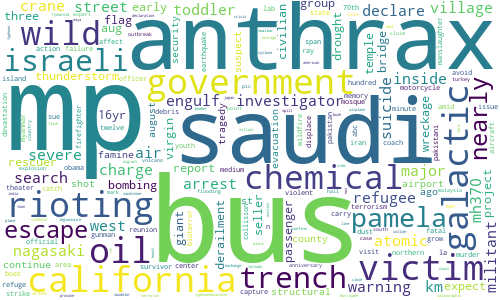

In [75]:
# A wordcloud of exlusive disaster words
wordcloud_exclusive_disaster = WordCloud(background_color='white', width=500, height=300, collocations=False).generate(' '.join(str(v) for v in exclusive_disaster_tweets))
wordcloud_exclusive_disaster.to_image()

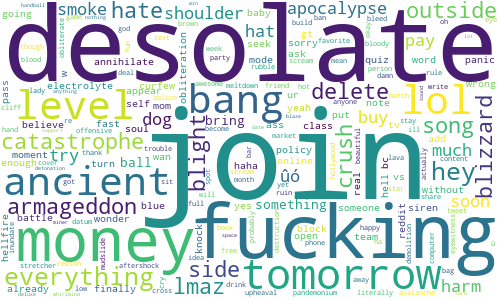

In [76]:
# A wordcloud of exlusive non disaster words
wordcloud_exclusive_nonDisaster = WordCloud(background_color='white', width=500, height=300, collocations=False).generate(' '.join(str(v) for v in exclusive_nondisaster_tweets))
wordcloud_exclusive_nonDisaster.to_image()

In [77]:
# A complete vocalbulary of exclusive disaster and non-disaster word tokens
complete_vocab_tokens = exclusive_disaster_tweets + exclusive_nondisaster_tweets

Once we have received a list of tokens for our complete vocabulary, we can create vectors, which will result in adding new features to the dataset, where each column represent a word from our complete vocabulary.

In [78]:
for word in complete_vocab_tokens:
    df_train['_'+word] = df_train['text'].apply(lambda x: (word in x)*1)
    df_test['_'+word] = df_test['text'].apply(lambda x: (word in x)*1)

In [79]:
df_train.sample(n=4)

,keyword,location,text,target,_bus,_mp,_anthrax,_saudi,_government,_galactic,...,_trust,_light,_might,_chance,_care,_zone,_stock,_resolution,_leather,_check
5561,rainstorm,thailand malaysia indonesia,nigeria rainstorm destroy 600 house lobe state...,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7148,volcano,indonesia,zeal volcano peak grass indecisiveness grow,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5909,sandstone,tractor land aka bristol,can not listen parade sandstone without expect...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4490,hurricane,,listen hurricane,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TFidf Vectorizer

Term Frequency (TF) is a metric that measures how often a term appears in a document.  
	TF(x) = (Number of times term x appears in a document) / (Total 		   number of terms in the document).

Inverse Document Frequency (IDF) is a metric which measures how important a term is across all documents.  
    IDF(x) = log_e(Total number of documents / Number of 				   documents with term ‘x’ in it)
    
   The TFidf processing is done to find the weightage/importance of each word in the complete vocabulary.
	

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Convert our collection of raw documents to a matrix of tf-idf features
#tfidf for text
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         max_features = 5000,
                         smooth_idf=False)

tfidf_train_text = tf_idf.fit_transform(df_train['text'])
tfidf_test_text = tf_idf.transform(df_test['text'])

#tfidf for keyword
tf_idf_keyword = TfidfVectorizer(ngram_range = (1,2),
                        binary = True,
                        max_features = 1500,
                        smooth_idf = False)

tfidf_train_keyword = tf_idf_keyword.fit_transform(df_train['keyword'])
tfidf_test_keyword = tf_idf_keyword.transform(df_test['keyword'])

#tfidf for location
tf_idf_location = TfidfVectorizer(ngram_range = (1,2),
                              binary = True,
                              max_features = 1500,
                              smooth_idf = False)
tfidf_train_location = tf_idf_location.fit_transform(df_train['location'])
tfidf_test_location = tf_idf_location.transform(df_test['location'])

In [81]:
tfidf_train_text

<7613x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 71187 stored elements in Compressed Sparse Row format>

In [82]:
# We will now concatinate the extracted features obtained from TFidf with 'df_train' dataframe.
df_train = pd.concat([df_train,pd.DataFrame(tfidf_train_text.toarray(),
                                                columns = ['_text_'+ str(text) for text in tf_idf.get_feature_names()]),
                        pd.DataFrame(tfidf_train_keyword.toarray(),
                                     columns = ['_keyword_'+str(text) for text in tf_idf_keyword.get_feature_names()]),
                        pd.DataFrame(tfidf_train_location.toarray(),
                                     columns = ['_location_'+str(text) for text in tf_idf_location.get_feature_names()])],axis = 1)

In [83]:
# We will now concatinate the extracted features obtained from TFidf with 'df_test' dataframe.
df_test = pd.concat([df_test,pd.DataFrame(tfidf_test_text.toarray(),
                                                columns = ['_text_'+ str(text) for text in tf_idf.get_feature_names()]),
                        pd.DataFrame(tfidf_test_keyword.toarray(),
                                     columns = ['_keyword_'+str(text) for text in tf_idf_keyword.get_feature_names()]),
                        pd.DataFrame(tfidf_test_location.toarray(),
                                     columns = ['_location_'+str(text) for text in tf_idf_location.get_feature_names()])],axis = 1)

In [84]:
df_train.sample(n=4)

,keyword,location,text,target,_bus,_mp,_anthrax,_saudi,_government,_galactic,...,_location_you,_location_you ûªve,_location_zealand,_location_zone,_location_ìït,_location_ìït 1061481786848072612195582811791382,_location_ûªs,_location_ûªt,_location_ûªve,_location_ûò
3836,first responder,franklin tn near nashville,shoot event theater give free coffee first res...,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4584,injury,mesa az,fucking go injury who s next,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3262,engulf,london,word describe physical painter rip apart strea...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2349,demolition,u fan plea,good grill u fan plea,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Columns: 7274 entries, keyword to _location_ûò
dtypes: float64(6756), int64(515), object(3)
memory usage: 422.5+ MB


We have now obtained our cleaned dataset in the form of vectors, which can be trained on a machine learning model. Our dataset in current form has original 7613 rows and a total of 7274 columns, where each column represents a vector of words.

Now that we have vectors formed for the complete vocabulary, we can now drop the original 'keyword', 'location' and 'text' columns as we no longer need these columns.

In [86]:
df_train = df_train.drop(['keyword','location','text'],axis = 1)
df_test = df_test.drop(['keyword','location','text'],axis = 1)

# Data Modelling

We will first train our models on only training dataset by splitting it into test and training datasets. The reason behind this is to understand the evaluation metrics our our models on training dataset.

In [211]:
X = df_train.drop('target',axis = 1)
y = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XG Boost Classifier

We will first start modelling our data on XG Boost. XGBoost is a decision-tree based ensemble Machine Learning technique that uses a gradient boosting framework.

XGBoosting is a great blend of software and hardware optimization techniques that produce superior outcomes in the shortest amount of time with the least amount of computing resources.

In [215]:
%%time
#import XGBClassifier from xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
# We are using GridSearchCV to estimate the best parameters on XGBClassifier
parameters = {'n_estimators':[50,100,200],'learning_rate':[0.01,0.1,1], 'max_depth':[5,8,10]}
xgb_tuned = XGBClassifier()
clf = GridSearchCV(xgb_tuned,parameters)
clf.fit(X_train, y_train)

[00:45:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:45:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:45:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:46:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:02:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:02:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:03:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:03:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:21:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:22:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:22:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:23:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:43:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:43:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:44:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:45:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:05:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:07:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:08:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:09:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
            

In [ ]:
# xgb_normal = XGBClassifier(n_estimators=200,learning_rate=0.1,max_depth=10)
# xgb_normal.fit(X_train, y_train)

In [216]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=6,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [217]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}

In [218]:
# Prediction on 0.3% of split training data 
xgb_pred = clf.predict(X_test)
print(classification_report(y_test,xgb_pred))
print(accuracy_score(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1318
           1       0.80      0.65      0.72       966

    accuracy                           0.78      2284
   macro avg       0.79      0.77      0.77      2284
weighted avg       0.79      0.78      0.78      2284

0.7832749562171629


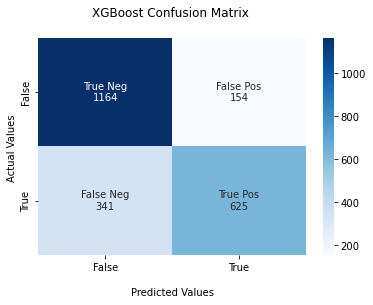

In [219]:
# Confusion Matrix for XGB model
cf_matrix_xgb = confusion_matrix(y_test, xgb_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_xgb.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_xgb, annot=labels, fmt='', cmap='Blues')

ax.set_title('XGBoost Confusion Matrix \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [221]:
# ROC AUC curve for XG Boost predictor
y_pred_prob_xgb = clf.predict_proba(X_test)[::,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb)

fig = px.area(
    x=fpr, y=tpr,
    title=f' XGBoost - Area under ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

# Multinomial Naive Bayes

A Naive Bayes classifier is a probabilistic machine learning model for classification problems. The Bayes theorem is the foundation of the Naive Bayes classifier.

Multinomial NB is commonly used to solve document classification problems. The frequency of the terms included in the document is one of the features/predictors used by the classifier.

In [169]:
from sklearn.naive_bayes import MultinomialNB
start_time = time.time()
NB_model = MultinomialNB().fit(X_train, y_train)
print("--- %s NB_Model seconds ---" % (time.time() - start_time))
NB_pred = NB_model.predict(X_test)
print("Accuracy Score: ",accuracy_score(y_test, NB_pred))
print("F1 Score: ",f1_score(y_test, NB_pred))

--- 0.24888086318969727 NB_Model seconds ---
Accuracy Score:  0.7876532399299475
F1 Score:  0.727986539540101


#### Hyperparameter Tuning for Naive Bayes

In [170]:
nb_param = {'alpha':[0.01,0.05,0.1,0.5,1.0],'fit_prior':[True, False]}
NB_tuned_model = MultinomialNB()
start_time = time.time()
NB_tuned_clf = GridSearchCV(NB_tuned_model,nb_param)
NB_tuned_clf.fit(X_train, y_train)
print("--- %s Tuned NB_Model seconds ---" % (time.time() - start_time))

--- 18.2592875957489 Tuned NB_Model seconds ---


In [171]:
NB_tuned_clf.best_estimator_

MultinomialNB(alpha=0.1)

In [172]:
NB_tuned_clf.best_params_

{'alpha': 0.1, 'fit_prior': True}

In [173]:
NB_tuned_pred = NB_tuned_clf.predict(X_test)
print("Accuracy Score: ",accuracy_score(y_test, NB_tuned_pred))

Accuracy Score:  0.7972854640980735


In [174]:
print (classification_report(y_test, NB_tuned_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1318
           1       0.80      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284



In [175]:
print("F1 Score: ", f1_score(y_test, NB_tuned_pred))

F1 Score:  0.7434903047091412


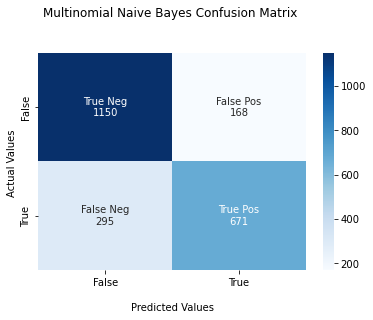

In [176]:
cf_matrix = confusion_matrix(y_test, NB_tuned_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Multinomial Naive Bayes Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [180]:
y_pred_proba = NB_tuned_clf.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig = px.area(
    x=fpr, y=tpr,
    title=f' Multinomial NB - Area under ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
plt.savefig("NB_AUC.png",bbox_inches='tight')
fig.show()

<Figure size 432x288 with 0 Axes>

# LSTM Model

In [181]:
from keras.layers import Dense, LSTM, Embedding, Activation
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from transformers import BertTokenizer
import warnings
warnings.filterwarnings('ignore')

In [182]:
df_lstm = pd.read_csv('processed_train.csv')
df_lstm = df_lstm.drop(['keyword','location'], axis=1)
df_lstm = df_lstm.dropna()
X = df_lstm.drop('target', axis=1)
y = df_lstm['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [183]:
tweets = X_train['text'].values
for i in range(5):
    print('{} : {}'.format(i, tweets[i]))

0 : mtr issue hazardous weather outlook
1 : chinas stock market crash gem rubble
2 : end
3 : man crush everyday
4 : hardly


In [184]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [185]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

Vectorize words for LSTM Model

In [186]:
max_len = 50
xtrain = []
for tweet in tweets:
    vec = encode_sentence(tweet)
    xtrain.append(vec[:max_len] + [0] * (max_len - len(vec)))

In [187]:
xtrain = np.array(xtrain)
n = np.amax(xtrain)
print(xtrain.shape)

(5098, 50)


In [188]:
ytrain = y_train.values
ytrain = np.array(ytrain)
print(ytrain.shape)

(5098,)


Vectorize Test Dataset

In [189]:
tweets = X_test['text'].values
max_len = 50
xtest = []
for tweet in tweets:
    vec = encode_sentence(tweet)
    xtest.append(vec[:max_len] + [0] * (max_len - len(vec)))

In [190]:
xtest = np.array(xtest)
n = np.amax(xtest)
print(xtest.shape)

(2512, 50)


In [191]:
ytest = y_test.values
ytest = np.array(ytest)
print(ytest.shape)

(2512,)


#### LSTM before tuning:

In [192]:
EPOCHS = 15
BATCH_SIZE = 32
lstm_model=Sequential()
lstm_model.add(Embedding(n + 1, BATCH_SIZE, mask_zero=True))
lstm_model.add(LSTM(BATCH_SIZE))
lstm_model.add(Dense(2, activation = 'sigmoid'))
optimizer = RMSprop(lr = 0.01)
lstm_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer)
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          3549664   
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3,558,050
Trainable params: 3,558,050
Non-trainable params: 0
_________________________________________________________________


In [193]:
%%time
lstm_model.fit(xtrain, ytrain, epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/15
160/160 [==============================] - 10s 28ms/step - loss: 0.5380
Epoch 2/15
160/160 [==============================] - 4s 26ms/step - loss: 0.3676
Epoch 3/15
160/160 [==============================] - 3s 21ms/step - loss: 0.2659
Epoch 4/15
160/160 [==============================] - 3s 21ms/step - loss: 0.2030
Epoch 5/15
160/160 [==============================] - 3s 21ms/step - loss: 0.1587
Epoch 6/15
160/160 [==============================] - 4s 22ms/step - loss: 0.1269
Epoch 7/15
160/160 [==============================] - 4s 23ms/step - loss: 0.1081
Epoch 8/15
160/160 [==============================] - 3s 22ms/step - loss: 0.0953
Epoch 9/15
160/160 [==============================] - 3s 22ms/step - loss: 0.0867
Epoch 10/15
160/160 [==============================] - 3s 22ms/step - loss: 0.0716
Epoch 11/15
160/160 [==============================] - 3s 22ms/step - loss: 0.0645
Epoch 12/15
160/160 [==============================] - 3s 22ms/step - loss: 0.0626
Epoch 13/15


In [194]:
lstm_pred_vals = [np.argmax(lstm_model.predict(np.array([x_test_]))) for x_test_ in xtest]

In [195]:
print(classification_report(ytest, lstm_pred_vals))
print("LSTM Accuracy Score: ",accuracy_score(ytest, lstm_pred_vals))
print("LSTM F1 Score:", f1_score(ytest, lstm_pred_vals))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1450
           1       0.64      0.69      0.67      1062

    accuracy                           0.71      2512
   macro avg       0.70      0.71      0.70      2512
weighted avg       0.71      0.71      0.71      2512

LSTM Accuracy Score:  0.7066082802547771
LSTM F1 Score: 0.666967916854948


#### LSTM with Hyper parameter tuning:

In [196]:
EPOCHS = 30
BATCH_SIZE = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=5)
tuned_lstm_model=Sequential()
tuned_lstm_model.add(Embedding(n + 1, BATCH_SIZE*2, mask_zero=True))
tuned_lstm_model.add(LSTM(BATCH_SIZE))
tuned_lstm_model.add(Dropout(0.5))
tuned_lstm_model.add(Dense(BATCH_SIZE, activation = 'relu'))
tuned_lstm_model.add(Dense(2, activation = 'sigmoid'))
optimizer = RMSprop(lr = 0.01)
tuned_lstm_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer)
tuned_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          7099328   
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 7,112,866
Trainable params: 7,112,866
Non-trainable params: 0
_________________________________________________________________


In [197]:
%%time
tuned_lstm_model.fit(xtrain, ytrain, epochs = EPOCHS, batch_size = 64, callbacks=[earlyStopping], validation_data=(xtest,ytest))

Epoch 1/30
80/80 [==============================] - 11s 64ms/step - loss: 0.5610 - val_loss: 0.4666
Epoch 2/30
80/80 [==============================] - 3s 36ms/step - loss: 0.3708 - val_loss: 0.4864
Epoch 3/30
80/80 [==============================] - 3s 36ms/step - loss: 0.2717 - val_loss: 0.5243
Epoch 4/30
80/80 [==============================] - 3s 35ms/step - loss: 0.1944 - val_loss: 0.7169
Epoch 5/30
80/80 [==============================] - 3s 36ms/step - loss: 0.1501 - val_loss: 0.9936
Epoch 6/30
80/80 [==============================] - 3s 35ms/step - loss: 0.1186 - val_loss: 0.7819
CPU times: total: 1min 4s
Wall time: 25.3 s


In [198]:
pred_vals = [np.argmax(tuned_lstm_model.predict(np.array([x_test_]))) for x_test_ in xtest]

In [199]:
print(classification_report(ytest, pred_vals))
print("Accuracy Score: ",accuracy_score(ytest, pred_vals))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      1450
           1       0.75      0.60      0.67      1062

    accuracy                           0.75      2512
   macro avg       0.75      0.73      0.73      2512
weighted avg       0.75      0.75      0.74      2512

Accuracy Score:  0.7472133757961783


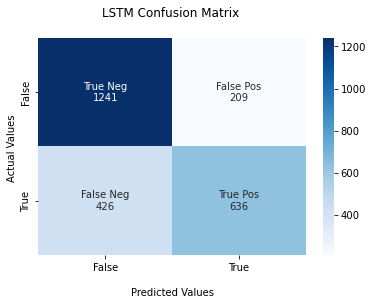

In [200]:
# Confusion matrix for LSTM model
cf_matrix_Lstm = confusion_matrix(ytest, pred_vals)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_Lstm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_Lstm, annot=labels, fmt='', cmap='Blues')

ax.set_title('LSTM Confusion Matrix \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [201]:
# ROC AUC Curve
y_pred_prob_lstm = tuned_lstm_model.predict(xtest)[::,1]

fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob_lstm)

fig = px.area(
    x=fpr, y=tpr,
    title=f' LSTM - Area under ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

### Applying our best model i.e Naive Bayes on the unseen test dataset

In [202]:
NB_complete_model = MultinomialNB(alpha=0.1).fit(df_train.drop('target', axis=1), df_train['target'])

In [203]:
NB_complete_pred = NB_complete_model.predict(df_test)

In [204]:
type(NB_complete_pred)

numpy.ndarray

In [205]:
sample_submission = pd.read_csv('sample_submission.csv')

In [207]:
sample_submission = sample_submission.drop('target', axis=1)

In [208]:
sample_submission['target'] = pd.DataFrame(NB_complete_pred)

In [209]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [210]:
sample_submission.to_csv("NB_completeDS_sample_submission.csv", index=False)

## The End.